In [3]:
from enum import Enum
import math

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn.ensemble import IsolationForest


from funclib.iolib import folder_open
from dblib import mssql


def roundx(v):
    '''(float)->float
    round to the more extreme value
    '''
    if v < 0:
        return math.floor(v)
    return math.ceil(v)


In [23]:
def cm2inch1(v):
    '''(int|float)->int|float
    '''
    return v / INCH

INCH = 2.54

class FigWidths(Enum):
    minimal = 3
    single_col = 9
    one_and_a_half_col = 14
    two_col = 19

def getwidth(sz, as_inch=True):
    '''(Enum:FigWidths|float, bool)->float

    Get publication fig widths in cm or inches
    '''
    assert isinstance(sz, FigWidths)
    return sz.value/INCH if as_inch else sz.value

H = getwidth(FigWidths.one_and_a_half_col)
W = H

In [20]:
#GET DATAFRAME FROM SQL

In [2]:
sql="select tl_mm, lens_subj_triangle_est, abs(rotation) as rotation ,accuracy ,hw_ratio, all_corr_rot_adj2_mm_error_perc as bias_percent, abs(all_corr_rot_adj2_mm_error_perc) as abs_bias_percent from v_mv_long_form where cnn = 'nas' and (transform like 'r%' or transform like 'none') and accuracy>0.5"

with mssql.Conn('imagedb', '(local)') as cnn:
    df_hwratio = pd.read_sql(sql, cnn)
list(df_hwratio)

['tl_mm',
 'lens_subj_triangle_est',
 'rotation',
 'accuracy',
 'hw_ratio',
 'bias_percent',
 'abs_bias_percent']

In [4]:
rotation = np.array(df_hwratio.rotation)
accuracy = np.array(df_hwratio.accuracy)
hw_ratio = np.array(df_hwratio.hw_ratio)
bias_percent = np.array(df_hwratio.bias_percent)
n_samples = rotation.shape[0]

#bias_percent vs hw_ratio
hw_bias = np.c_[hw_ratio, bias_percent]
hw_bias_acc = np.c_[hw_ratio, bias_percent, accuracy]
print('hw_bias.shape: %s   hw_bias_acc.shape: %s' % (hw_bias.shape, hw_bias_acc.shape))


hw_bias.shape: (16508, 2)   hw_bias_acc.shape: (16508, 3)


In [32]:
# Example settings
rng = np.random.RandomState(28)
outliers_fraction = 0.1
xlim = (0, 1); ylim = (-70, 30)

In [33]:
#RANDOM FOREST ON HW_BIAS

In [34]:
X = np.copy(hw_bias) #the data
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 100))

In [35]:
clf = IsolationForest(max_samples=n_samples, contamination=outliers_fraction, random_state=rng) #the classifier
clf.fit(X)
scores_pred = clf.decision_function(X)
y_pred = clf.predict(X)

threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

levels=[threshold, Z.max()]
levels.sort()
print('Done')


Done


In [36]:
#PLOT IT

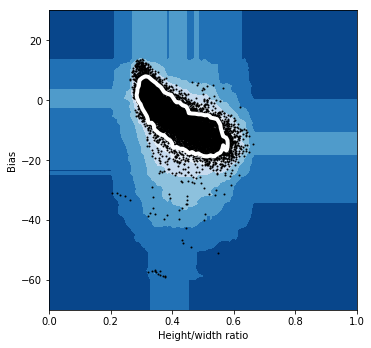

In [37]:
plt.figure(figsize=(W, H))
ax = plt.gca()


plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)
#plt.contourf(xx, yy, Z, levels=[threshold, Z.max()].sort(), colors='orange')

b = plt.scatter(X[:,0], X[:,1], c='white', s=1, edgecolor='k')
a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=4, colors='white')


plt.axis('tight')
#plt.legend([a.collections[0], b, c], ['learned decision function', 'true inliers', 'true outliers'], prop=matplotlib.font_manager.FontProperties(size=10), loc='lower right')
ax.set_xlabel('Height/width ratio')
ax.set_ylabel('Bias')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/hw_outliers.svg', dpi=500)
plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/hw_outliers.jpg')
folder_open('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images')

plt.show()

In [ ]:
#Now BOTH ACCURACY, BIAS AND RATIO

In [38]:
X = np.copy(hw_bias_acc)

(16508, 3)

In [ ]:
#PLOT IT

In [40]:
clf = IsolationForest(max_samples=n_samples, contamination=outliers_fraction, random_state=rng) #the classifier
clf.fit(X)
scores_pred = clf.decision_function(X)
y_pred = clf.predict(X)

threshold = stats.scoreatpercentile(scores_pred, 100 * outliers_fraction)

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

levels=[threshold, Z.max()]
levels.sort()
print('Done')

IndexError: index 2 is out of bounds for axis 1 with size 2

In [53]:
x_inlier = X[y_pred == 1]
x_outlier = X[y_pred == -1]
#hw_bias_acc = np.c_[hw_ratio, bias_percent, accuracy]



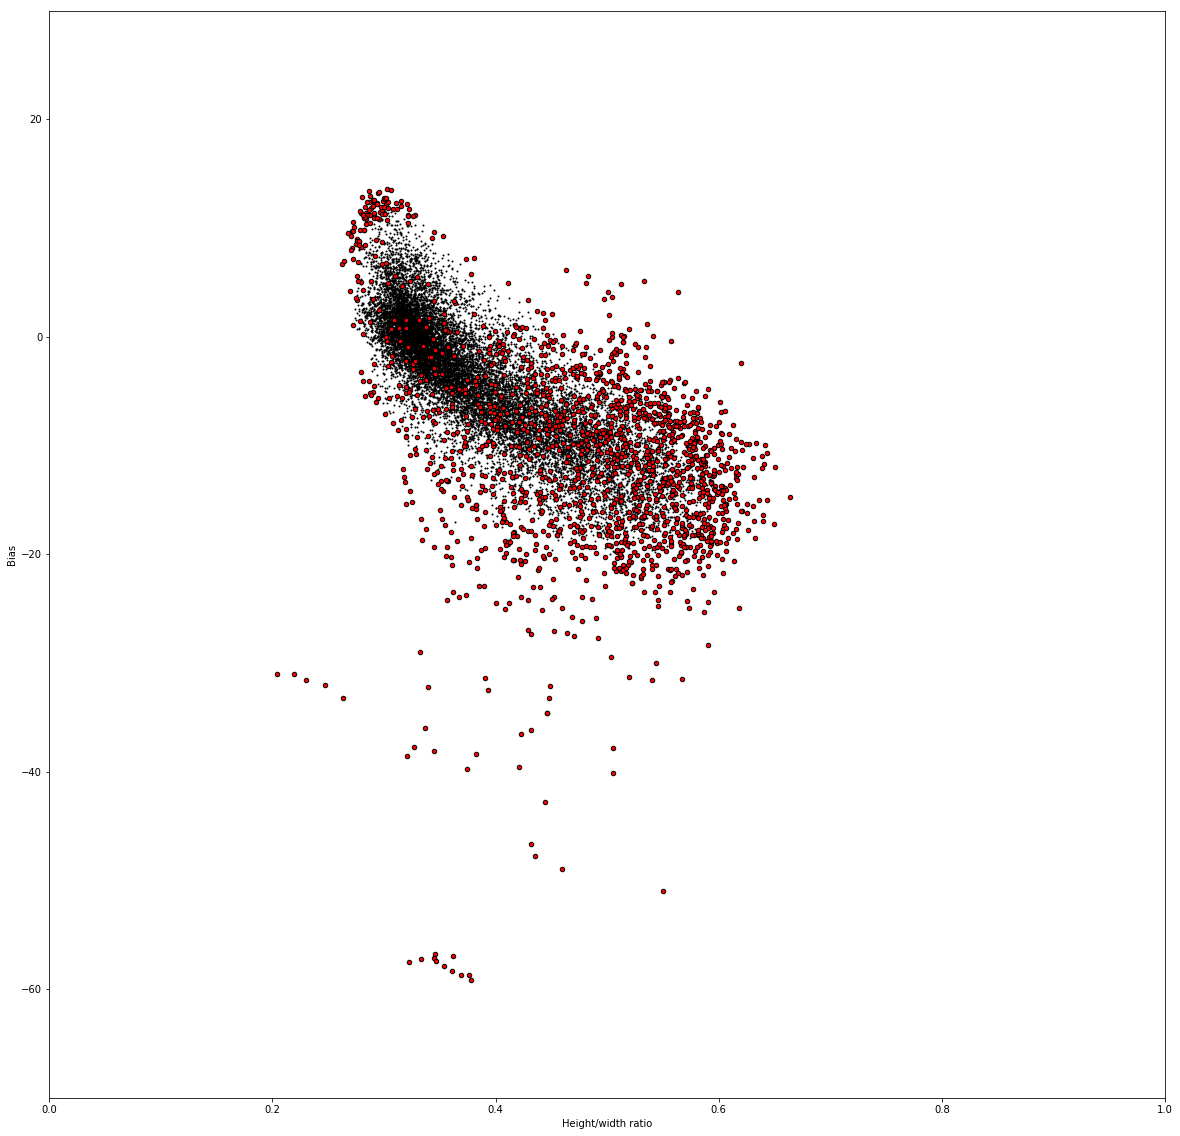

In [62]:
plt.close()
plt.figure(figsize=(20, 20))
ax = plt.gca()


a = plt.scatter(x_inlier[:,0], x_inlier[:,1], c='white', s=1, edgecolor='k')
b = plt.scatter(x_outlier[:,0], x_outlier[:,1], c='red', s=20, edgecolor='k')
plt.axis('tight')
ax.set_xlabel('Height/width ratio')
ax.set_ylabel('Bias')
ax.set_xlim(xlim)
ax.set_ylim(ylim)

#plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/hw_outliers.svg', dpi=500)
#plt.savefig('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images/hw_outliers.jpg')
#folder_open('C:/Users/Graham Monkman/OneDrive/Documents/PHD/My Papers/Fiducial_machine_vision_estimates/images')

plt.show()

(1651, 3)

(16508, 3)